In [51]:
%load_ext autoreload
from script.feature_extractor import FeatureExtractor
from script.classifier import Classifier
from script.signal_manager import SignalMgr
from script.filter import Filter
from script.data_reader import DataReader
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
INVALID_SLIGHT_DATA_FPATH='/Volumes/workspace/projects/signal_classification/data/特殊次品样本/斜角_轻微.20190515/'
INVALID_BAD_DATA_FPATH='/Volumes/workspace/projects/signal_classification/data/特殊次品样本/斜角_严重.20190515/'
FULL_DATA_FAPTH='/Volumes/workspace/projects/signal_classification/data/1005_0830重新标注文件_Data._20180609.0830'

In [53]:
data_reader = DataReader()

In [54]:
norm_df = data_reader.create_single_index(FULL_DATA_FAPTH+'/'+'result.csv').drop(labels='sys_result', axis=1)
norm_df[norm_df.reason==4].describe()
norm_df.head()

,case_name,channel_id,case_path,expect_result,reason
0,20180325_090536,1,/Volumes/workspace/projects/signal_classificat...,0,-1
1,20180325_090637,1,/Volumes/workspace/projects/signal_classificat...,1,9
2,20180325_091016,1,/Volumes/workspace/projects/signal_classificat...,1,5
3,20180325_091047,1,/Volumes/workspace/projects/signal_classificat...,1,5
4,20180325_091103,1,/Volumes/workspace/projects/signal_classificat...,1,5


In [55]:
invalid_slight_df = data_reader.get_signal_list(INVALID_SLIGHT_DATA_FPATH).drop(labels=['sys_result'], axis=1)
invalid_slight_df['expect_result'] = 1
invalid_slight_df['reason'] = 61
invalid_slight_df.head()

,case_name,channel_id,case_path,expect_result,reason
0,20190515_204352497,1,/Volumes/workspace/projects/signal_classificat...,1,61
1,20190515_204352497,2,/Volumes/workspace/projects/signal_classificat...,1,61
2,20190515_204352497,3,/Volumes/workspace/projects/signal_classificat...,1,61
3,20190515_204352497,4,/Volumes/workspace/projects/signal_classificat...,1,61
4,20190515_204352497,5,/Volumes/workspace/projects/signal_classificat...,1,61


In [56]:
invalid_bad_df = data_reader.get_signal_list(INVALID_BAD_DATA_FPATH).drop(labels=['sys_result'], axis=1)
invalid_bad_df['expect_result'] = 1
invalid_bad_df['reason'] = 62
invalid_bad_df.head()

,case_name,channel_id,case_path,expect_result,reason
0,20190515_203431979,1,/Volumes/workspace/projects/signal_classificat...,1,62
1,20190515_203431979,2,/Volumes/workspace/projects/signal_classificat...,1,62
2,20190515_203431979,3,/Volumes/workspace/projects/signal_classificat...,1,62
3,20190515_203431979,4,/Volumes/workspace/projects/signal_classificat...,1,62
4,20190515_203431979,5,/Volumes/workspace/projects/signal_classificat...,1,62


In [57]:
sigMgr = SignalMgr()
# feature = sigMgr.get_features(path1, request_param={'skip_row':[1], 'model_path':['train']})

In [58]:
# 开始进行模型迭代和训练, 整合训练数据和测试数据

def data_prepare(train_path, test_path, eval_path):
    # 预留长短波形的数据用于数据的测试
    msk = np.random.rand(len(invalid_bad_df)) < 0.8
    invalid_bad_train_df = invalid_bad_df[msk]         #用于训练
    invalid_bad_eval_df = invalid_bad_df[~msk]         #用于最后验证
    
    msk = np.random.rand(len(invalid_slight_df)) < 0.8
    invalid_slight_train_df = invalid_slight_df[msk]
    invalid_slight_eval_df = invalid_slight_df[~msk]
    
    eval_mix_df = invalid_bad_eval_df.append(invalid_slight_eval_df).reset_index(drop=True)
    # 获取整体的训练数据
    train_mix_df = invalid_slight_train_df.append(invalid_bad_train_df).reset_index(drop=True)
    # 再次划分为测试集合与训练集合
    msk = np.random.rand(len(train_mix_df)) < 0.8
    train_df = train_mix_df[msk]
    test_df = train_mix_df[~msk]

    # pandas 写入到文件中进行缓存，用于迭代测试，避免出现每次划分数据集合auc发生变化
    train_df.to_csv(train_path, index=False)
    test_df.to_csv(test_path, index=False)
    eval_mix_df.to_csv(eval_path, index=False)

In [59]:
# data_prepare("../data/train_skew.csv", "../data/test_skew.csv", "../data/eval_skew.csv")

In [60]:
data_root = '../data'
# 开始进行特征的获取
train_tmp_df = pd.read_csv(data_root + '/' + 'train.csv')
train_skew_df = pd.read_csv(data_root + '/' + 'train_skew.csv')
train_df = train_tmp_df.append(train_skew_df).reset_index(drop=True)

In [61]:
test_tmp_df = pd.read_csv(data_root + '/' + 'test.csv')
test_skew_df = pd.read_csv(data_root + '/' + 'test_skew.csv')
test_df = test_tmp_df.append(test_skew_df).reset_index(drop=True)

In [62]:
normal_cases = train_df[train_df.expect_result == 0]
other_defect_cases = train_df[(train_df.expect_result == 1) & (train_df.reason != 6) & (train_df.reason != 61) & (train_df.reason != 62)]
defet_cases = train_df[(train_df.reason == 6) | (train_df.reason == 61) | (train_df.reason == 62)]

In [63]:
def get_features(df):
    mu_list = []
    delta_list = []
    sigMgr = SignalMgr()
    for path in df['case_path']:
        feature = sigMgr.get_features(path, request_param={'skip_row':[1], 'model_path':['train']})
        mu_list.append(np.mean(feature['unit_interviene_length_diff']))
        delta_list.append(np.std(feature['unit_interviene_length_diff']))
    return np.min(mu_list), np.max(mu_list), np.min(delta_list), np.max(delta_list), np.mean(mu_list), np.mean(delta_list)

In [64]:
# 整体数据的区分很大，因此介入进行数据分析和训练
feature_names = ['peaks_num', 'down_peaks_num', 'up_edges_num', 'down_edges_num', 'peak_edge_ratio', 'down_peak_edge_ratio',
                 'edge_diff_10', 'edge_diff_20', 'width_diff_10', 'negative_peak_num', 'max_down_peak_point', 'inter_diff_mean', 'inter_diff_delta',
                'skewness_mean', 'skewness_delta']

feature_names = sorted(feature_names, reverse=True)
                
def features(df_full, feature_names):
    pathes = df_full['case_path']
    # print pathes
    feature_set = dict()
    for name in feature_names:
        feature_set[name] = list()
#     feature_set['inter_diff_mean'] = list()
#     feature_set['inter_diff_delta'] = list()
#     feature_set['skewness_mean'] = list()
#     feature_set['skewness_delta'] = list()
#     feature_set['skewness_median'] = list()
#     feature_set['skewness_10'] = list()
#     feature_set['skewness_20'] = list()
#     feature_set['skewness_30'] = list()
#     feature_set['skewness_']
    
    for test_case in pathes:
        features = sigMgr.get_features(test_case, request_param={'skip_row':[1], 'model_path':['train']})
        for name in feature_names:
            feature_set[name].append(features[name])
#         feature_set['inter_diff_mean'].append(np.mean(features['unit_interviene_length_diff']))
#         feature_set['inter_diff_delta'].append(np.std(features['unit_interviene_length_diff']))
#         skewness_list = sorted(features['unit_interviene_skewness'], reverse=True)
#         feature_set['skewness_median'] = np.percentile(skewness_list, 50)
#         feature_set['skewness_10'] = np.percentile(skewness_list, 90)
#         feature_set['skewness_20'] = np.percentile(skewness_list, 80)
#         feature_set['skewness_30'] = np.percentile(skewness_list, 70)
#         feature_set['skewness_mean'].append(np.mean(features['unit_interviene_skewness']))
#         feature_set['skewness_delta'].append(np.std(features['unit_interviene_skewness']))
    
    return pd.DataFrame(feature_set)

In [65]:
train_x = features(train_df, feature_names)
train_y = train_df['expect_result']
test_x = features(test_df, feature_names)
test_y = test_df['expect_result']

train_y[train_y == -1] = 0
test_y[test_y == -1] = 0
test_x = test_x.fillna(0)
train_x = train_x.fillna(0)
# test_df = pd.read_csv(data_root + '/' + 'test.csv')
# test_x = features(test_df, feature_names)
# test_y = test_df['expect_result']

/Users/changkong/anaconda3/envs/tpy2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/changkong/anaconda3/envs/tpy2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [66]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier as ada
from sklearn.linear_model import LogisticRegression as lg
from sklearn.metrics import classification_report

gdbtModel = GradientBoostingClassifier()
gdbtModel.fit(train_x, train_y)
pResult = gdbtModel.predict(test_x)
print(classification_report(test_y, pResult))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       632
           1       0.94      0.95      0.94      1093

   micro avg       0.93      0.93      0.93      1725
   macro avg       0.92      0.92      0.92      1725
weighted avg       0.93      0.93      0.93      1725



In [83]:
from sklearn.externals import joblib
joblib.dump(gdbtModel, '../production/model.gbdt.2019.06.18')

['../production/model.gbdt.2019.06.18']

In [67]:
eval_df = pd.read_csv(data_root + '/' + 'eval_skew.csv')
eval_df_x = features(eval_df, feature_names)
eval_df_y = eval_df['expect_result']

pResult = gdbtModel.predict(eval_df_x)
print(classification_report(eval_df_y, pResult))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.79      0.88        76

   micro avg       0.79      0.79      0.79        76
   macro avg       0.50      0.39      0.44        76
weighted avg       1.00      0.79      0.88        76



In [68]:
hard_eval_df = eval_df[eval_df.reason == 61]
eval_df_x = features(hard_eval_df, feature_names)
eval_df_y = hard_eval_df['expect_result']
pResult = gdbtModel.predict(eval_df_x)
print(classification_report(eval_df_y, pResult))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.80      0.89        50

   micro avg       0.80      0.80      0.80        50
   macro avg       0.50      0.40      0.44        50
weighted avg       1.00      0.80      0.89        50



In [69]:
hard_eval_df = eval_df[eval_df.reason == 62]
eval_df_x = features(hard_eval_df, feature_names)
eval_df_y = hard_eval_df['expect_result']
pResult = gdbtModel.predict(eval_df_x)
print(classification_report(eval_df_y, pResult))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.77      0.87        26

   micro avg       0.77      0.77      0.77        26
   macro avg       0.50      0.38      0.43        26
weighted avg       1.00      0.77      0.87        26



In [70]:
# 开始斜边的波形调研，先看用现有的基线能得到多好的测试结果
SKEW_DATA_FPATH='/Volumes/workspace/projects/signal_classification/data/特殊次品样本/斜角_严重.20190515/'
data_reader = DataReader()
skew_angel_df = data_reader.get_signal_list(SKEW_DATA_FPATH)
skew_angel_df['expect_result'] = 1

0.020120134994599075
0.021672262919400158


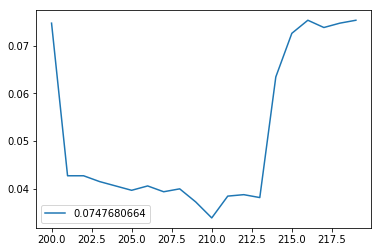

In [71]:
path = skew_angel_df.head()['case_path'][4]
signals = pd.read_csv(path, skiprows=1)
signals[200:220].plot()
feas = sigMgr.get_features(path, request_param={'skip_row':[1], 'model_path':['train']})
# medfiltered_signals = Filter.medfilter(normalized_signals, 9)
print(np.mean(feas['unit_interviene_skewness']))
print(np.std(feas['unit_interviene_skewness']))

In [72]:
feas = sigMgr.get_features(path, request_param={'skip_row':[1], 'model_path':['train']})
# medfiltered_signals = Filter.medfilter(normalized_signals, 9)
print(np.mean(feas['unit_interviene_skewness']))
print(np.std(feas['unit_interviene_skewness']))

0.020120134994599075
0.021672262919400158


0.025705034826682228
0.03476858544217898


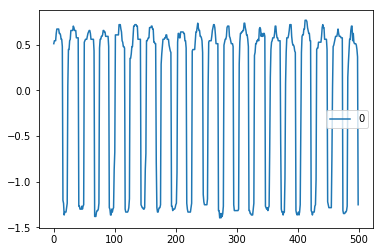

In [73]:
path = normal_cases['case_path'].reset_index(drop=True)[6]
feas = sigMgr.get_features(path, request_param={'skip_row':[1], 'model_path':['train']})
normalized_signals = feas['normalized_signals'] 
medfiltered_signals = Filter.medfilter(normalized_signals, 5)
pd.DataFrame(medfiltered_signals)[0:500].plot()
print(np.mean(feas['unit_interviene_skewness']))
print(np.std(feas['unit_interviene_skewness']))

In [74]:
# 开始斜边的波形调研，先看用现有的基线能得到多好的测试结果
SKEW_DATA_FPATH='/Volumes/workspace/projects/signal_classification/data/特殊次品样本/斜角_严重.20190515/'
data_reader = DataReader()
skew_angel_df = data_reader.get_signal_list(SKEW_DATA_FPATH)
skew_angel_df['expect_result'] = 1
skew_unit_skewness_list = []
for path in skew_angel_df['case_path']:
    feas = sigMgr.get_features(path, request_param={'skip_row':[1], 'model_path':['train']})
    skew_unit_skewness_list.extend(feas['unit_interviene_skewness'])

In [75]:
print (np.mean(skew_unit_skewness_list), np.std(skew_unit_skewness_list))

(0.025293953059877358, 0.05032384093612252)


In [76]:
SKEW_DATA_FPATH_LIGHT='/Volumes/workspace/projects/signal_classification/data/特殊次品样本/斜角_轻微.20190515/'
skew_light_angel_df = data_reader.get_signal_list(SKEW_DATA_FPATH_LIGHT)
skew_light_angel_df['expect_result'] = 1
skew_unit_skewness_list = []
for path in skew_light_angel_df['case_path']:
    feas = sigMgr.get_features(path, request_param={'skip_row':[1], 'model_path':['train']})
    count = 0
    for angel in feas['unit_interviene_skewness']:
        if angel > (0.0124 + 1 * 0.035):
            count+=1
    skew_unit_skewness_list.append(count)
#     skew_unit_skewness_list.extend(feas['unit_interviene_skewness'])
print (np.mean(skew_unit_skewness_list), np.std(skew_unit_skewness_list))

(3.152027027027027, 2.9352003843974326)


In [77]:
import math
new_List = []
for val in skew_unit_skewness_list:
    if math.isnan(val) or math.isinf(val):
        continue
    new_List.append(val)

In [78]:
print (np.mean(new_List), np.std(new_List))

(3.152027027027027, 2.9352003843974326)


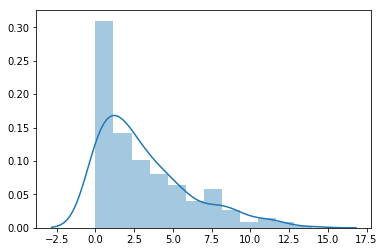

In [79]:
import seaborn as sns

sns.distplot(new_List)

In [80]:
goods = []
for path in norm_df[norm_df.expect_result == 0]['case_path']:
    feas = sigMgr.get_features(path, request_param={'skip_row':[1], 'model_path':['train']})
    count = 0
    for angel in feas['unit_interviene_skewness']:
        if angel > (0.0124 + 1 * 0.035):
            count+=1
    goods.append(count)
print (np.mean(goods), np.std(goods))

(2.1559792027729636, 2.0874975987700606)


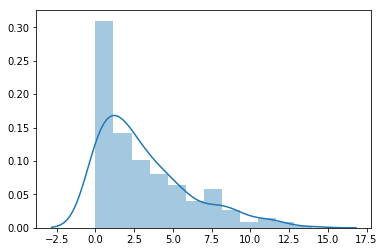

In [81]:
sns.distplot(new_List)